### Data Dictionary

For this project, you will be creating a movie recommendation system using the MovieLens dataset. The version of movielens included in the dslabs package (which was used for some of the exercises in PH125.8x: Data Science: Machine Learning) is just a small subset of a much larger dataset with millions of ratings. You can find the entire latest MovieLens dataset here. You will be creating your own recommendation system using all the tools we have shown you throughout the courses in this series. We will use the 10M version of the MovieLens dataset to make the computation a little easier.

You will download the MovieLens data and run code we will provide to generate your datasets.

First, there will be a short quiz on the MovieLens data. You can view this quiz as an opportunity to familiarize yourself with the data in order to prepare for your project submission.

Second, you will train a machine learning algorithm using the inputs in one subset to predict movie ratings in the validation set. Your project itself will be assessed by peer grading.


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import string

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.2)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')


# from pycaret.classification import *
# from pycaret.clustering import *
# from pycaret.regression import *

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Data Exploration

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df

,userId,movieId,rating,timestamp,title,genres
0,1,122,5.0,838985046,Boomerang (1992),Comedy|Romance
1,1,185,5.0,838983525,"Net, The (1995)",Action|Crime|Thriller
2,1,292,5.0,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller
3,1,316,5.0,838983392,Stargate (1994),Action|Adventure|Sci-Fi
4,1,329,5.0,838983392,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi
...,...,...,...,...,...,...
9000050,32620,33140,3.5,1173562747,Down and Derby (2005),Children|Comedy
9000051,40976,61913,3.0,1227767528,Africa addio (1966),Documentary
9000052,59269,63141,2.0,1226443318,Rockin' in the Rockies (1945),Comedy|Musical|Western
9000053,60713,4820,2.0,1119156754,Won't Anybody Listen? (2000),Documentary


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000055 entries, 0 to 9000054
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(3), object(2)
memory usage: 412.0+ MB


In [5]:
df.describe(include='all')

,userId,movieId,rating,timestamp,title,genres
count,9.000055e+06,9.000055e+06,9.000055e+06,9.000055e+06,9000055,9000055
unique,NaN,NaN,NaN,NaN,10676,797
top,NaN,NaN,NaN,NaN,Pulp Fiction (1994),Drama
freq,NaN,NaN,NaN,NaN,31362,733296
mean,3.586982e+04,4.121702e+03,3.512465e+00,1.032616e+09,NaN,NaN
std,2.058525e+04,8.942108e+03,1.060331e+00,1.159668e+08,NaN,NaN
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08,NaN,NaN
25%,1.812400e+04,6.480000e+02,3.000000e+00,9.467683e+08,NaN,NaN
50%,3.573800e+04,1.834000e+03,4.000000e+00,1.035494e+09,NaN,NaN
75%,5.360700e+04,3.626000e+03,4.000000e+00,1.126751e+09,NaN,NaN


In [6]:
df.shape

(9000055, 6)

In [7]:
df.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres'], dtype='object')

In [8]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

### How many rows and columns are there in the edx dataset?
9000055 rows × 6 columns

### How many zeros were given as ratings in the edx dataset?

In [9]:
df['rating'].value_counts()

4.0    2588430
3.0    2121240
5.0    1390114
3.5     791624
2.0     711422
4.5     526736
1.0     345679
2.5     333010
1.5     106426
0.5      85374
Name: rating, dtype: int64

### How many different movies are in the edx dataset?

In [10]:
df['movieId'].nunique()

10677

### How many different users are in the edx dataset?

In [11]:
df['userId'].nunique()

69878

### How many movie ratings are in each of the following genres in the edx dataset?

In [14]:
drama = df[df['genres'].str.contains('Drama')]
drama

,userId,movieId,rating,timestamp,title,genres
2,1,292,5.0,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller
4,1,329,5.0,838983392,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi
6,1,356,5.0,838983653,Forrest Gump (1994),Comedy|Drama|Romance|War
8,1,364,5.0,838983707,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical
14,1,539,5.0,838984068,Sleepless in Seattle (1993),Comedy|Drama|Romance
...,...,...,...,...,...,...
9000031,71567,1876,3.0,912580722,Deep Impact (1998),Drama|Sci-Fi|Thriller
9000041,71567,2028,5.0,912580344,Saving Private Ryan (1998),Action|Drama|War
9000047,16929,39412,3.0,1221160134,Living 'til the End (2005),Drama
9000049,30445,8394,0.5,1200074027,"Hi-Line, The (1999)",Drama


In [15]:
comedy = df[df['genres'].str.contains('Comedy')]
comedy

,userId,movieId,rating,timestamp,title,genres
0,1,122,5.0,838985046,Boomerang (1992),Comedy|Romance
5,1,355,5.0,838984474,"Flintstones, The (1994)",Children|Comedy|Fantasy
6,1,356,5.0,838983653,Forrest Gump (1994),Comedy|Drama|Romance|War
9,1,370,5.0,838984596,Naked Gun 33 1/3: The Final Insult (1994),Action|Comedy
11,1,420,5.0,838983834,Beverly Hills Cop III (1994),Action|Comedy|Crime|Thriller
...,...,...,...,...,...,...
9000040,71567,2012,3.0,912580722,Back to the Future Part III (1990),Comedy|Sci-Fi|Western
9000044,71567,2294,5.0,912577968,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
9000046,71567,2384,2.0,912578173,Babe: Pig in the City (1998),Children|Comedy
9000050,32620,33140,3.5,1173562747,Down and Derby (2005),Children|Comedy


In [16]:
thriller = df[df['genres'].str.contains('Thriller')]
thriller

,userId,movieId,rating,timestamp,title,genres
1,1,185,5.0,838983525,"Net, The (1995)",Action|Crime|Thriller
2,1,292,5.0,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller
10,1,377,5.0,838983834,Speed (1994),Action|Romance|Thriller
11,1,420,5.0,838983834,Beverly Hills Cop III (1994),Action|Comedy|Crime|Thriller
21,2,376,3.0,868245920,"River Wild, The (1994)",Action|Thriller
...,...,...,...,...,...,...
9000042,71567,2107,1.0,912580553,Halloween H20: 20 Years Later (1998),Horror|Thriller
9000043,71567,2126,2.0,912649143,Snake Eyes (1998),Action|Crime|Mystery|Thriller
9000045,71567,2338,2.0,912578016,I Still Know What You Did Last Summer (1998),Horror|Mystery|Thriller
9000048,20306,63826,4.0,1228431590,Splinter (2008),Action|Horror|Thriller


In [17]:
romance = df[df['genres'].str.contains('Romance')]
romance

,userId,movieId,rating,timestamp,title,genres
0,1,122,5.0,838985046,Boomerang (1992),Comedy|Romance
6,1,356,5.0,838983653,Forrest Gump (1994),Comedy|Drama|Romance|War
7,1,362,5.0,838984885,"Jungle Book, The (1994)",Adventure|Children|Romance
10,1,377,5.0,838983834,Speed (1994),Action|Romance|Thriller
14,1,539,5.0,838984068,Sleepless in Seattle (1993),Comedy|Drama|Romance
...,...,...,...,...,...,...
8999989,71566,380,4.0,830340802,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller
8999995,71566,595,5.0,830340834,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance
9000005,71567,788,4.0,912580787,"Nutty Professor, The (1996)",Comedy|Fantasy|Romance|Sci-Fi
9000025,71567,1721,4.0,912649271,Titanic (1997),Drama|Romance


### Which movie has the greatest number of ratings?

In [21]:
movieratings = df.groupby(by='title', as_index=False).sum()
movieratings

,title,userId,movieId,rating,timestamp
0,"""Great Performances"" Cats (1998)",195396,205488,13.0,4920586249
1,'Round Midnight (1986),1501843,1195380,165.5,53622792417
2,'Til There Was You (1997),9623175,209551,764.5,258641487620
3,"'burbs, The (1989)",49139143,2782696,3982.5,1385264193836
4,'night Mother (1986),6352838,609952,676.0,194617666652
...,...,...,...,...,...
10671,eXistenZ (1999),95255943,6822400,8720.5,2760624564977
10672,ffolks (a.k.a. North Sea Hijack) (1980),945649,140643,81.0,29076898962
10673,loudQUIETloud: A Film About the Pixies (2006),275310,357889,26.5,8589367484
10674,xXx: State of the Union (2005),10618143,9648978,637.5,338749329610


In [24]:
movieratings['rating'].max()

130302.5

In [25]:
movieratings[movieratings['rating'] == 130302.5]

,title,userId,movieId,rating,timestamp
7663,Pulp Fiction (1994),1123622378,9283152,130302.5,30779490598225


### What are the five most given ratings in order from most to least?

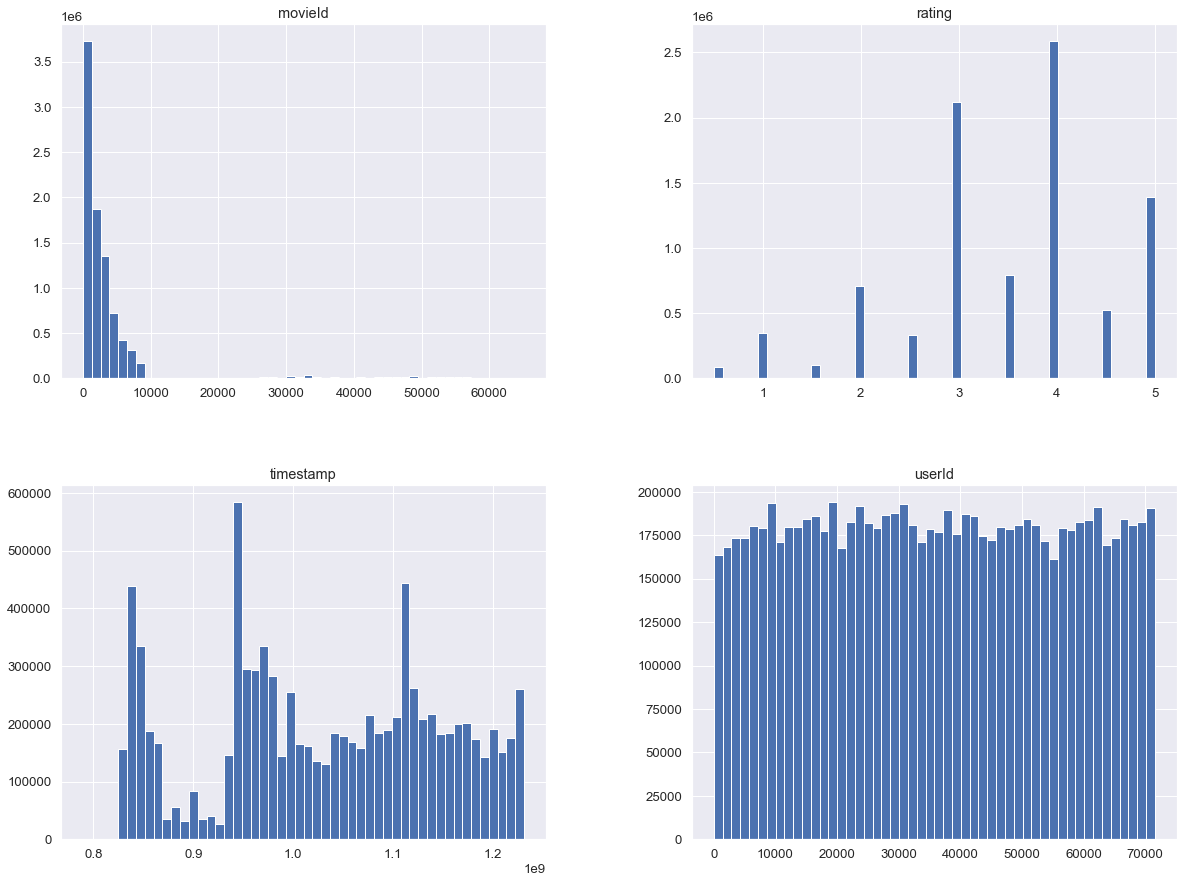

In [27]:
df.hist(bins=50, figsize=(20,15));

### True or False: In general, half star ratings are less common than whole star ratings (e.g., there are fewer ratings of 3.5 than there are ratings of 3 or 4, etc.).

In [28]:
df['rating'].value_counts()

4.0    2588430
3.0    2121240
5.0    1390114
3.5     791624
2.0     711422
4.5     526736
1.0     345679
2.5     333010
1.5     106426
0.5      85374
Name: rating, dtype: int64

Answer is True

###################       END OF PART 1        ################